# Camera Calibration

We'll take the images found in the camera_cal directory and obtain the calibration parameters for the camera in use. Our chessboard size is 9x6.

In [1]:
import os
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points
nx = 9
ny = 6

objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

objpoints = []
imgpoints = []

folder = "./camera_cal/"
pickle_file = folder + "camera_points.pickle"
if os.path.exists(pickle_file):
    # load pickle
    with open(pickle_file, 'rb') as f:
        pickle_data = pickle.load(f)
        objpoints = pickle_data["objpoints"]
        imgpoints = pickle_data["imgpoints"]
        del pickle_data
else:
    for fname in os.listdir(folder):
        img = cv2.imread(folder + fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        shape = (img.shape[0:2][1], img.shape[0:2][0])

        # If found, add to collections
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
    # save pickle
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    "objpoints": objpoints,
                    "imgpoints": imgpoints,
                },
                pfile, pickle.DEFAULT_PROTOCOL)
    except Exception as e:
        print("Unable to save data to", pickle_file, ":", e)
        raise


[[  1.24027474e+00   3.01579242e-01  -1.55474403e+02]
 [ -1.48946293e-02   1.31778590e+00   2.36231326e+01]
 [ -4.21588173e-05   5.08014068e-04   1.00000000e+00]]


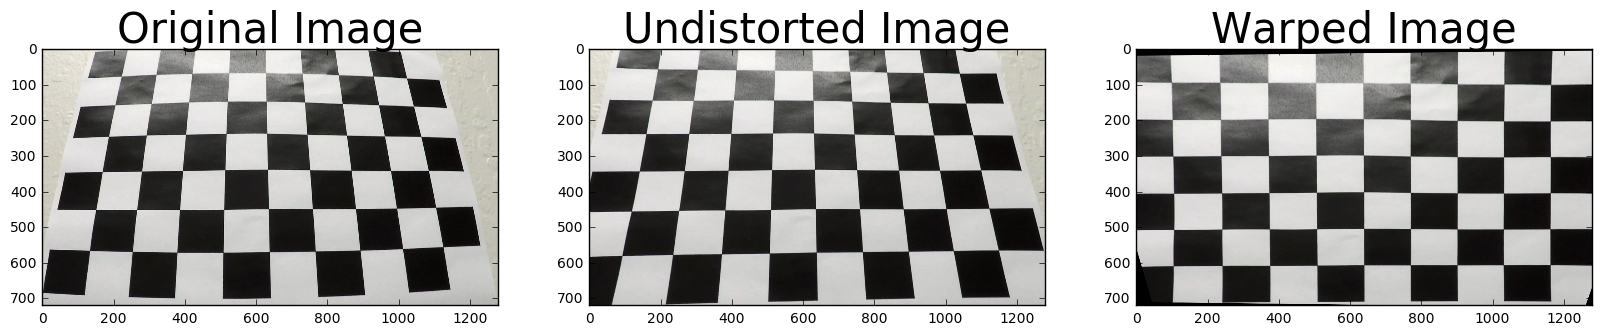

In [2]:

# Test the calibration numbers
def extract_edge_corners(corners, nx, ny):
    top_left = 0
    top_right = top_left + (nx -1)
    bottom_left = (ny - 1) * nx
    bottom_right = bottom_left + (nx - 1)
    return np.float32([
        corners[top_left][0],
        corners[top_right][0],
        corners[bottom_right][0],
        corners[bottom_left][0]
        ])

def create_expected_edge_corners(shape, nx, ny):
    max_x = shape[0]
    max_y = shape[1]
    segment_x = 1 / nx
    segment_y = 1 / ny
    return np.float32([
        [max_x * segment_x, max_y * segment_y],
        [max_x * (segment_x * (nx - 1)), max_y * segment_y],
        [max_x * (segment_x * (nx - 1)), max_y * (segment_y * (ny - 1))],
        [max_x * segment_x, max_y * (segment_y * (ny - 1))]
        ])

img = cv2.imread(folder + "calibration3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, size ,None, None)
undist = cv2.undistort(img, mtx, dist, None, mtx)
shape = (img.shape[0:2][1], img.shape[0:2][0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret:
    src = extract_edge_corners(corners, nx, ny)
    dst = create_expected_edge_corners(shape, nx, ny)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, shape, flags=cv2.INTER_LINEAR)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(undist)
    ax2.set_title('Undistorted Image', fontsize=30)
    ax3.imshow(warped)
    ax3.set_title('Warped Image', fontsize=30)

print(M)

# Pipeline (test images)

Let's test test the camera correction values on the test images.

Test image


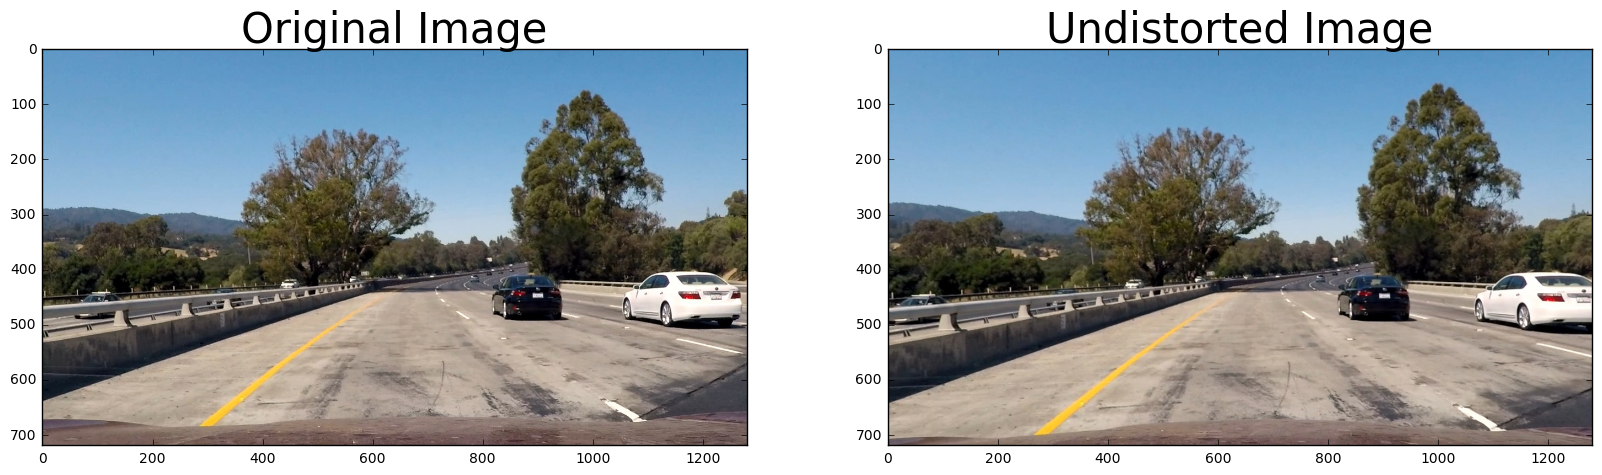

In [187]:
def camera_undistort(img):
    size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, size ,None, None)
    return cv2.undistort(img, mtx, dist, None, mtx)

img = cv2.imread("test_images/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = camera_undistort(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
print("Test image")

testfolder = "./test_images/"
outputimages = "./output_images/"
for fname in os.listdir(testfolder):
    img = cv2.imread(testfolder + fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist = camera_undistort(img)
    mpimg.imsave(outputimages + "1.undistorted-" + fname, undist)

Test image


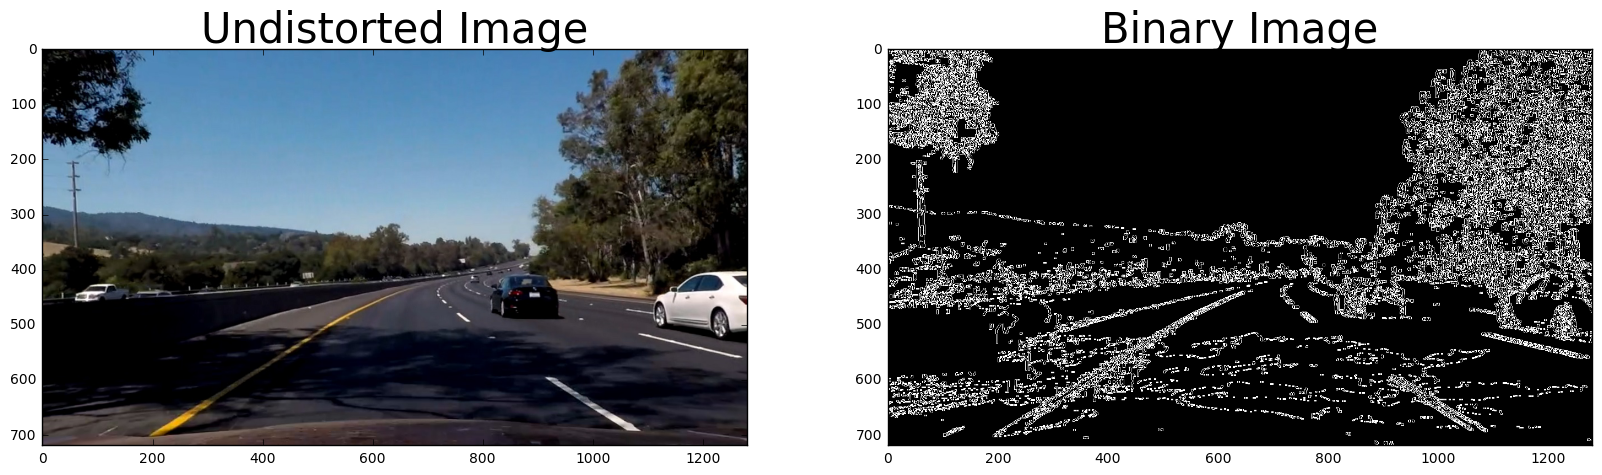

In [188]:
def thresholded_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100), gd_thresh=(0, np.pi/2), sobel_kernel=3):
    img = np.copy(img)
    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x on L channel to obtain x gradient
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.sqrt(sobelx**2)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))    
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold S channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine
    binary = np.zeros_like(sxbinary)
    binary[(sxbinary == 1) | (s_binary == 1)] = 1
    return binary

def double_thresholded_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100), gd_thresh=(0, np.pi/2), sobel_kernel=3):
    binary = thresholded_binary(img)
    binary_3d = np.dstack((binary, binary, binary))*255
    return thresholded_binary(binary_3d, sobel_kernel=5)

img = cv2.imread("test_images/extra_image.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = camera_undistort(img)
binary = double_thresholded_binary(undist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Binary Image', fontsize=30)
print("Test image")

testfolder = "./test_images/"
outputimages = "./output_images/"
for fname in os.listdir(testfolder):
    img = cv2.imread(testfolder + fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist = camera_undistort(img)
    binary = double_thresholded_binary(undist)
    mpimg.imsave(outputimages + "2.binary-" + fname, binary)

Test image, straight lines


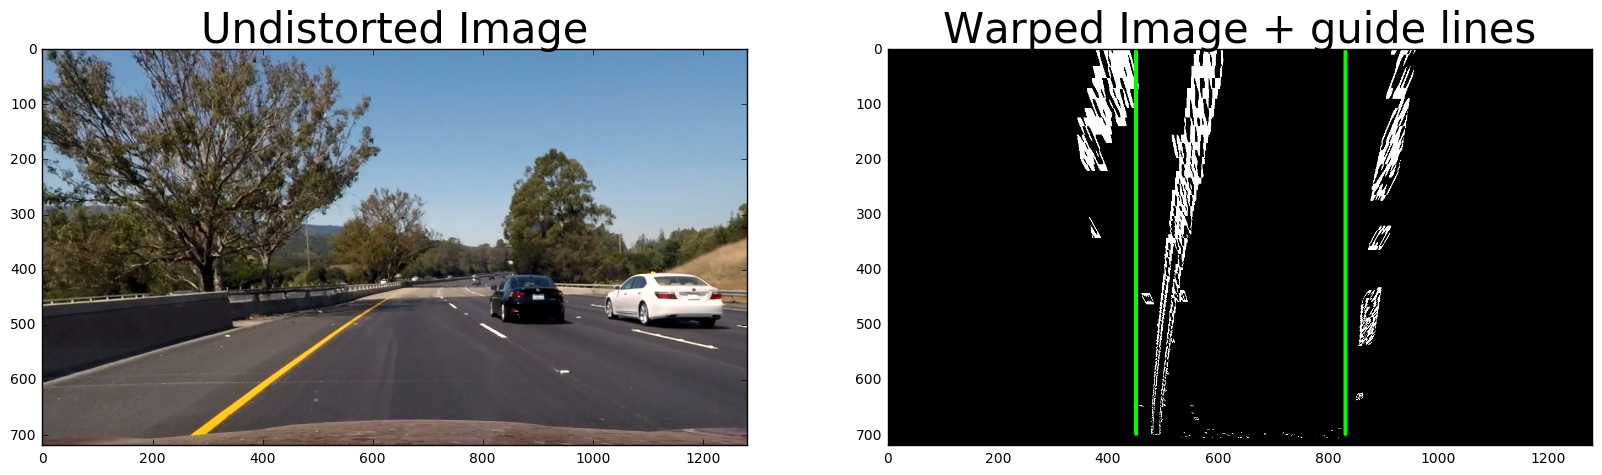

In [227]:
def perspective_transform(img):
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    imshape = img.shape
    xbottomleftlimit=imshape[1]*0.1
    xbottomrightlimit=imshape[1]*0.9
    xtopleftlimit=imshape[1]*0.45
    xtoprightlimit=imshape[1]*0.55
    ytoplimit=imshape[0]*0.60
    mask = np.zeros_like(img)
    work_area1 = np.array([[(xbottomleftlimit, imshape[0]),(xtopleftlimit, ytoplimit), (xtoprightlimit, ytoplimit), (xbottomrightlimit,imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, work_area1, ignore_mask_color)
    w1 = cv2.bitwise_and(img, mask)
    src = np.float32([
            (585, 455),
            (695, 455),
            (1080, 700),
            (200, 700)
        ])
    dst = np.float32([
            (450, 0),
            (830, 0),
            (830, 700),
            (450, 700)
        ])
    M = cv2.getPerspectiveTransform(src, dst)
    w2 = cv2.warpPerspective(w1, M, shape, flags=cv2.INTER_LINEAR)
    mask = np.zeros_like(img)
    work_area2 = np.array([[(imshape[1]/4, 0), (imshape[1]/4*3, 0), (imshape[1]/3*2, imshape[0]), (imshape[1]/3, imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, work_area2, ignore_mask_color)
    return cv2.bitwise_and(w2, mask)
    

#img = cv2.imread("test_images/straight_lines1.jpg")
img = cv2.imread("test_images/test6.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = camera_undistort(img)
binary = double_thresholded_binary(undist)
warped = perspective_transform(binary)
warped_3d = np.dstack((warped, warped, warped))*255
cv2.line(warped_3d, (450,0), (450,700), (0, 255, 0), 5)
cv2.line(warped_3d, (830,0), (830,700), (0, 255, 0), 5)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(warped_3d)
ax2.set_title('Warped Image + guide lines', fontsize=30)
print("Test image, straight lines")

testfolder = "./test_images/"
outputimages = "./output_images/"
for fname in os.listdir(testfolder):
    img = cv2.imread(testfolder + fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist = camera_undistort(img)
    binary = double_thresholded_binary(undist)
    warped = perspective_transform(binary)
    mpimg.imsave(outputimages + "3.warped-" + fname, warped)

Test image


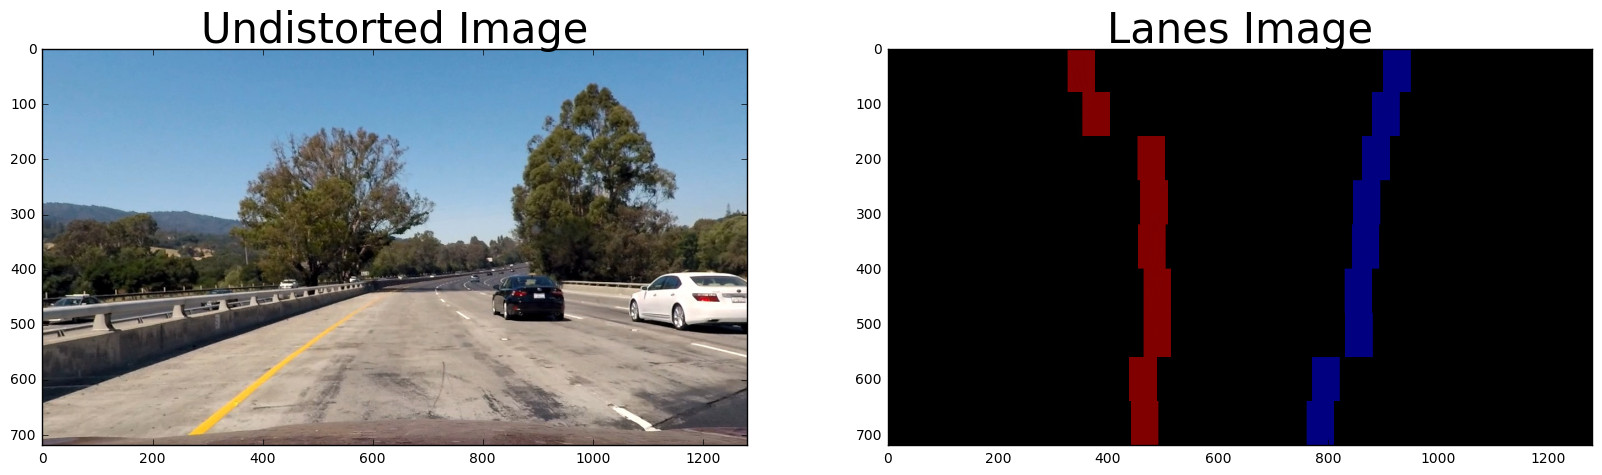

In [228]:
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append(np.int_([l_center, r_center]))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center + offset - margin, 0))
        l_max_index = int(min(l_center + offset + margin, image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index : l_max_index]) + l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center + offset - margin, 0))
        r_max_index = int(min(r_center + offset + margin, image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append(np.int_([l_center, r_center]))

    return np.array(window_centroids)

def lane_line_pixels_convolution(img):
    shape = (img.shape[0:2][1], img.shape[0:2][0])
    window_width = 50 
    window_height = int(shape[1] / 9)
    margin = 100 # How much to slide left and right for searching
    window_centroids = find_window_centroids(img, window_width, window_height, margin)
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel 
        template = np.array(cv2.merge((l_points,zero_channel,r_points)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        return cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    return img

img = cv2.imread("test_images/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = camera_undistort(img)
binary = double_thresholded_binary(undist)
warped = perspective_transform(binary)
lanes = lane_line_pixels_convolution(warped)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(lanes)
ax2.set_title('Lanes Image', fontsize=30)
print("Test image")

testfolder = "./test_images/"
outputimages = "./output_images/"
for fname in os.listdir(testfolder):
    img = cv2.imread(testfolder + fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist = camera_undistort(img)
    binary = double_thresholded_binary(undist)
    warped = perspective_transform(binary)
    lanes = lane_line_pixels_convolution(warped)
    mpimg.imsave(outputimages + "4.lanes_convolution-" + fname, lanes)

Test image
Detected curvature
L: 5836.46100016 R: 5836.46100016


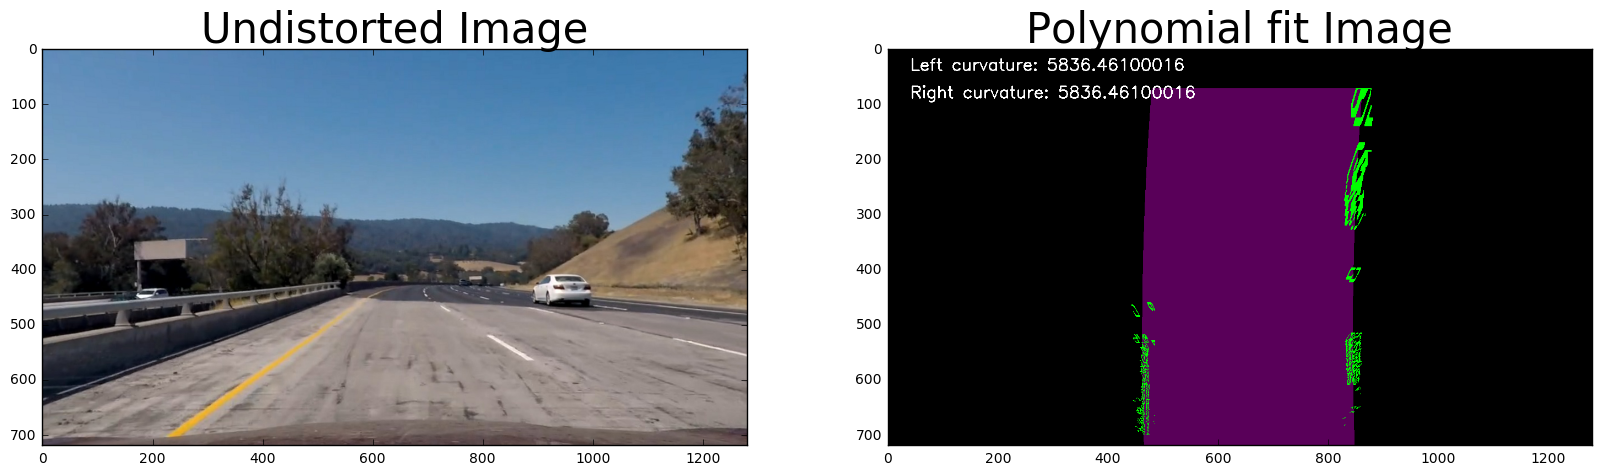

In [234]:
def lane_line_polynomials(img, last_known_polynomials):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*0
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 25 #9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 20 #50
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    if last_known_polynomials is None:
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    else:
        smaller_margin = int(margin / 1)
        left_fit = last_known_polynomials[0]
        right_fit = last_known_polynomials[1]
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - smaller_margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + smaller_margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - smaller_margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + smaller_margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Calculate curvature
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
            
    # Calculate the points for the left and right sides of the fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    # Verify if we have to correct one of the lanes, based on curvature ratio
    curverad_ratio = left_curverad / right_curverad
    left_base = left_line_window[0][left_line_window[0].shape[0]-1-40][0]
    right_base = right_line_window[0][40][0]
    base_delta = (right_base - left_base)
    replace_left = False
    replace_right = False
    if curverad_ratio <= 1/3:
        # Left side is 4x as curved as right side, let's discard the left side
        replace_left = True
    elif curverad_ratio >= 3:
        # Right side is 4x as curved as right side, let's discard the right side
        replace_right = True
    elif (left_fit[0] < 0 and right_fit[0] > 0) or (left_fit[0] > 0 and right_fit[0] < 0):
        # Lines diverge, take the one with the smallest curvature
        replace_left = left_curverad > right_curverad
        replace_right = not(replace_left)
    if replace_left:
        left_line_window = ((np.array([np.flipud(right_line_window[0])]) - [base_delta, 0]) * [1, 0]) + (left_line_window * [0, 1])
        left_curverad = right_curverad
    elif replace_right:
        right_line_window = ((np.array([np.flipud(left_line_window[0])]) + [base_delta, 0]) * [1, 0]) + (right_line_window * [0, 1])
        right_curverad = left_curverad
    
    # Paint the polynomial and the lane data that took us there
    lane_pts = np.hstack((left_line_window, right_line_window))
    cv2.fillPoly(out_img, np.int_([lane_pts]), (89, 0, 89))
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [0, 255, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 255, 0]
    
    # Crop the top, where most of the noise happens
    imshape = out_img.shape
    top = np.array([[(imshape[1]/4, 0), (imshape[1]/4*3, 0), (imshape[1]/4*3, imshape[0]/10), (imshape[1]/4, imshape[0]/10)]], dtype=np.int32)
    cv2.fillPoly(out_img, top, [0, 0, 0])
    return out_img, np.array([left_fit, right_fit]), left_curverad, right_curverad

img = cv2.imread("test_images/extra_image3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = camera_undistort(img)
binary = double_thresholded_binary(undist)
warped = perspective_transform(binary)
lanes, known_polynomials, left_curverad, right_curverad = lane_line_polynomials(warped, None)
text = "Left curvature: " + str(left_curverad)
cv2.putText(lanes, text, (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
text = "Right curvature: " + str(right_curverad)
cv2.putText(lanes, text, (40,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(lanes)
ax2.set_title('Polynomial fit Image', fontsize=30)
print("Test image")
print("Detected curvature")
print("L:", left_curverad, "R:", right_curverad)

testfolder = "./test_images/"
outputimages = "./output_images/"
for fname in os.listdir(testfolder):
    img = cv2.imread(testfolder + fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist = camera_undistort(img)
    binary = double_thresholded_binary(undist)
    warped = perspective_transform(binary)
    lanes, known_polynomials, left_curverad, right_curverad = lane_line_polynomials(warped, None)
    text = "Left curvature: " + str(left_curverad)
    cv2.putText(lanes, text, (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    text = "Right curvature: " + str(right_curverad)
    cv2.putText(lanes, text, (40,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    mpimg.imsave(outputimages + "5.lanes_polynomial-" + fname, lanes)

Test image


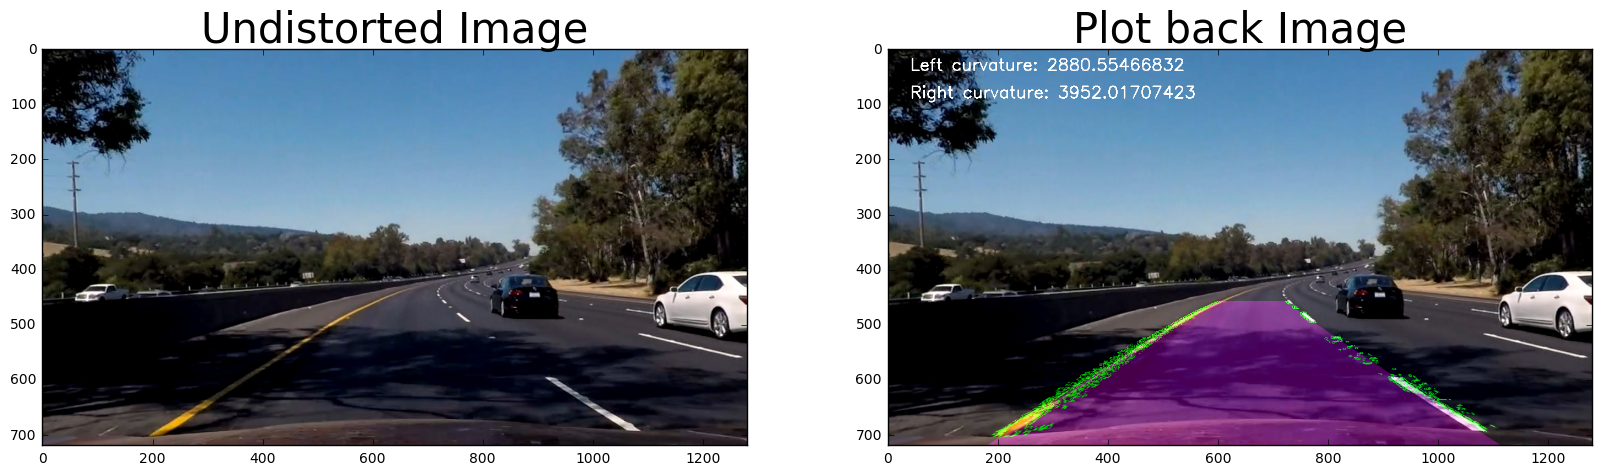

In [235]:
def plot_back(img, lanes):
    src = np.float32([
            (450, 0),
            (830, 0),
            (830, 700),
            (450, 700)
        ])
    dst = np.float32([
            (585, 455),
            (695, 455),
            (1080, 700),
            (200, 700)
        ])
    M = cv2.getPerspectiveTransform(src, dst)
    lanes = cv2.warpPerspective(lanes, M, shape, flags=cv2.INTER_LINEAR)
    return cv2.addWeighted(img, 1, lanes, 0.8, 0)

img = cv2.imread("test_images/extra_image.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = camera_undistort(img)
binary = double_thresholded_binary(undist)
warped = perspective_transform(binary)
lanes, known_polynomials, left_curverad, right_curverad = lane_line_polynomials(warped, None)
plotted = plot_back(undist, lanes)
text = "Left curvature: " + str(left_curverad)
cv2.putText(plotted, text, (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
text = "Right curvature: " + str(right_curverad)
cv2.putText(plotted, text, (40,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(plotted)
ax2.set_title('Plot back Image', fontsize=30)
print("Test image")

testfolder = "./test_images/"
outputimages = "./output_images/"
for fname in os.listdir(testfolder):
    img = cv2.imread(testfolder + fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist = camera_undistort(img)
    binary = double_thresholded_binary(undist)
    warped = perspective_transform(binary)
    lanes, known_polynomials, left_curverad, right_curverad = lane_line_polynomials(warped, None)
    plotted = plot_back(undist, lanes)
    text = "Left curvature: " + str(left_curverad)
    cv2.putText(plotted, text, (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    text = "Right curvature: " + str(right_curverad)
    cv2.putText(plotted, text, (40,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    mpimg.imsave(outputimages + "6.plotted-" + fname, plotted)

# Define the final pipeline

In [236]:
def pipeline(img, previously_known_polynomials):
    undist = camera_undistort(img)
    binary = double_thresholded_binary(undist)
    warped = perspective_transform(binary)
    lanes, new_known_polynomials, left_curverad, right_curverad = lane_line_polynomials(warped, previously_known_polynomials)
    text = "Left curvature: " + str(left_curverad)
    cv2.putText(undist, text, (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    text = "Right curvature: " + str(right_curverad)
    cv2.putText(undist, text, (40,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    return plot_back(undist, lanes), new_known_polynomials

# Now, let's process the video
Process first the provided `project_video.mp4`, and produce a file called `processed_project_video.mp4`.

In [237]:
# Import everything needed to edit/save/watch video clips
import imageio

from moviepy.editor import VideoFileClip
from IPython.display import HTML

processing_state = None
def process_image(image):
    global processing_state 
    result, processing_state = pipeline(image, processing_state)
    return result

In [238]:
processed_output = 'processed_project_video.mp4'
original_clip = VideoFileClip("project_video.mp4")
processing_state = None
processed_clip = original_clip.fl_image(process_image)
%time processed_clip.write_videofile(processed_output, audio=False)

[MoviePy] >>>> Building video processed_project_video.mp4
[MoviePy] Writing video processed_project_video.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [14:34<00:00,  1.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_project_video.mp4 

Wall time: 14min 35s


In [239]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(processed_output))